In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [3]:
models = ['b-resnet', 'b-densenet', 'msdnet']
tests = ['confidence', 'score-margin']
nets = { model : {test : {} for test in tests} for model in models}
nets['b-densenet']['confidence'] = pd.read_csv('bdensnenet_threshold_confidence1.csv', index_col=0)
nets['b-densenet']['score-margin'] = pd.read_csv('bdensnenet_threshold_score_margin1.csv', index_col=0)

nets['b-resnet']['confidence'] = pd.read_csv('bresnet_threshold_confidence1.csv', index_col=0)
nets['b-resnet']['score-margin'] = pd.read_csv('bresnet_threshold_score_margin1.csv', index_col=0)

nets['msdnet']['confidence'] = pd.read_csv('msdnet_confidence1.csv', index_col=0)
nets['msdnet']['score-margin'] = pd.read_csv('msdnet_score_margin1.csv', index_col=0)
nets['msdnet']['confidence']

,threshold,test,exit,sample,exited,prediction,target,correct,score
0,0.1,0,0,0,1,0,0,True,0.976271
1,0.1,0,1,0,1,0,0,True,0.998661
2,0.1,0,2,0,1,0,0,True,0.999627
3,0.1,0,3,0,1,0,0,True,0.999534
4,0.1,0,4,0,1,0,0,True,0.999984
...,...,...,...,...,...,...,...,...,...
224995,0.9,8,0,4999,0,99,99,True,0.553061
224996,0.9,8,1,4999,0,99,99,True,0.848673
224997,0.9,8,2,4999,1,99,99,True,0.937880
224998,0.9,8,3,4999,1,99,99,True,0.996193


In [4]:
print('B-ResNet last exit {}'.format(nets['b-resnet']['score-margin'].groupby('exit').correct.mean()[3:]))
print('B-DenseNet last exit {}'.format(nets['b-densenet']['score-margin'].groupby('exit').correct.mean()[3:]))
print('MSDNet last exit {}'.format(nets['msdnet']['score-margin'].groupby('exit').correct.mean()[4:]))

B-ResNet last exit exit
3    0.893
Name: correct, dtype: float64
B-DenseNet last exit exit
3    0.879
Name: correct, dtype: float64
MSDNet last exit exit
4    0.867
Name: correct, dtype: float64


In [5]:
def analyze_df(models, exits):
    tests = ['confidence', 'score-margin']
    data = {
        model : {
            test : {
                'exited' : {},
                'correct' : {},
                'incorrect': {},
                'accuracy': {}
            }
            for test in tests
        }
        for model in models
    }
    
    for model, n in zip(models, exits):
        for test in models[model]:
            for exit in range(n):
                exited = []
                accuracy = []
                correct = []
                incorrect = []
                for t in np.arange(0.1, 1, 0.1):
                    n_exited = len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                             & (models[model][test]['exit'] == exit)
                                             & (models[model][test]['exited']==1)])
                    exited.append(n_exited)
                    
                    correct.append((len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                            & (models[model][test]['exit'] == exit) 
                                                            & (models[model][test]['correct'] == 1) 
                                                            & (models[model][test]['exited']==1)])))
                    incorrect.append((len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                    & (models[model][test]['exit'] == exit) 
                                                    & (models[model][test]['correct'] == 0) 
                                                    & (models[model][test]['exited']==1)])))
                    
                    accuracy.append(len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                  & (models[model][test]['exit'] == exit) 
                                                  & (models[model][test]['exited']==1) 
                                                  & (models[model][test]['correct']==1)])/n_exited)
                    
                data[model][test]['exited']['exit-{}'.format(exit)] = exited
                #th_exit_acc.append(exit_n_acc)
                #th_false_if_exited.append(exit_n_false)
                data[model][test]['accuracy']['exit-{}'.format(exit)] = accuracy
                #th_time.append(exit_time)
                data[model][test]['correct']['exit-{}'.format(exit)]  = correct
                data[model][test]['incorrect']['exit-{}'.format(exit)] = incorrect

    
    return data
    

In [6]:
output = analyze_df(nets, exits=[4, 4, 5])

# Exit accuracy

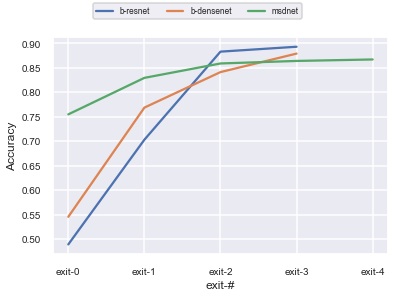

In [7]:
fig, ax = plt.subplots(1,1)
for model in nets:
    correct = nets[model]['confidence'].groupby('exit').correct.mean()
    #print(correct)
    sns.lineplot(data=correct, ax=ax)

x = np.arange(0,5,1)
ax.set_xticks(x)
ax.set_xticklabels(['exit-{}'.format(n) for n in x])
ax.set(xlabel='exit-#', ylabel='Accuracy')
fig.legend(['{}'.format(model) for model in nets], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=3, fontsize='small')
plt.savefig('exit_acc.png')


NameError: name 'export_legend' is not defined

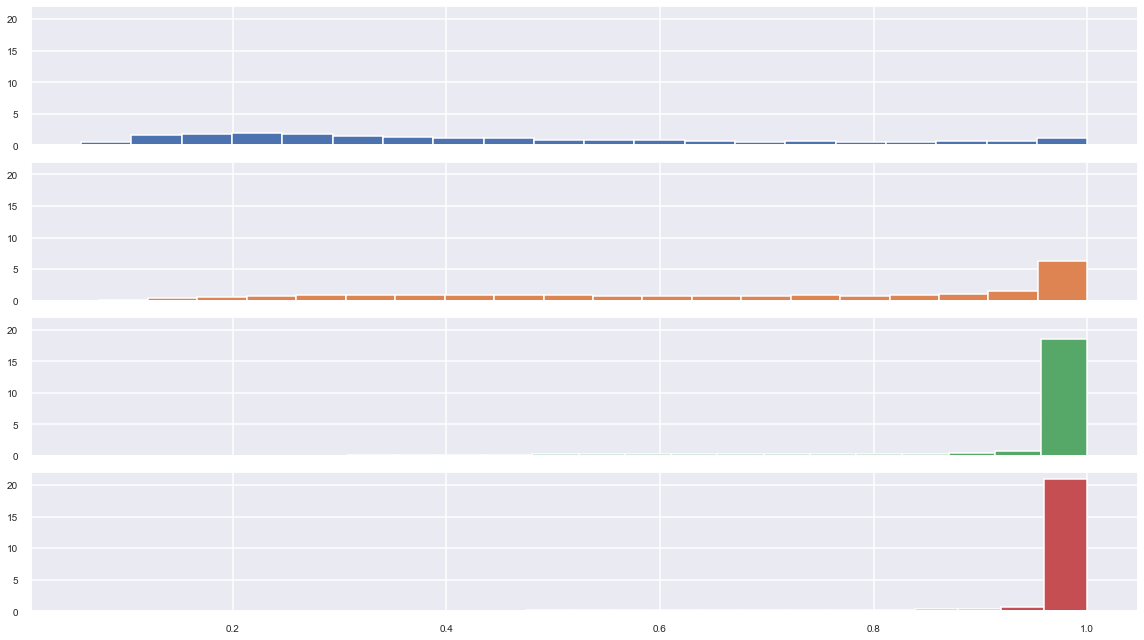

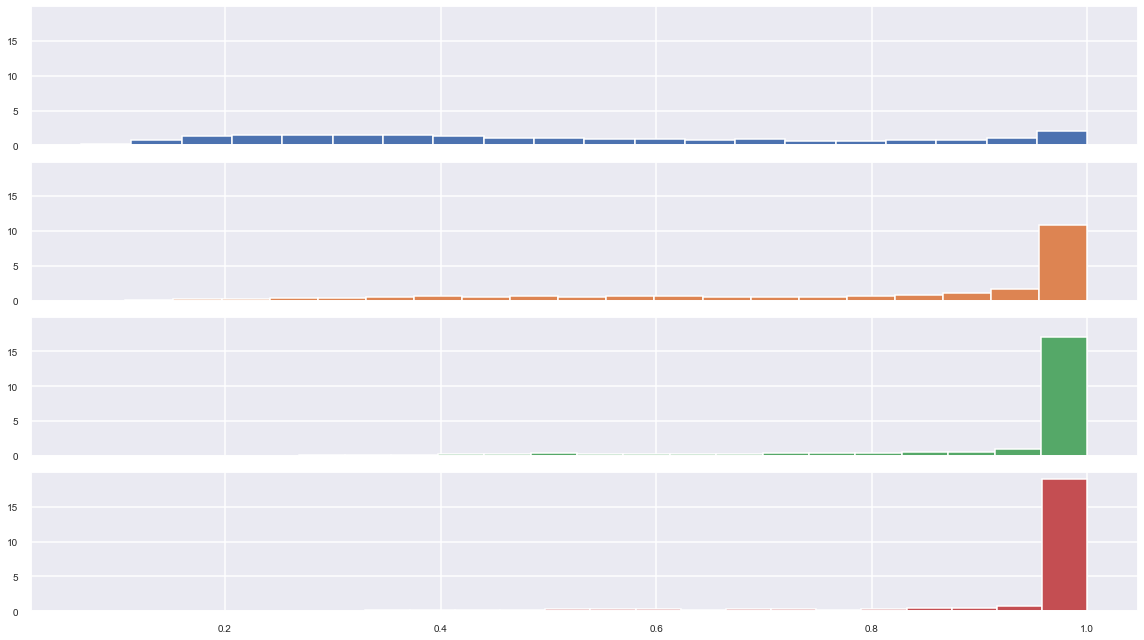

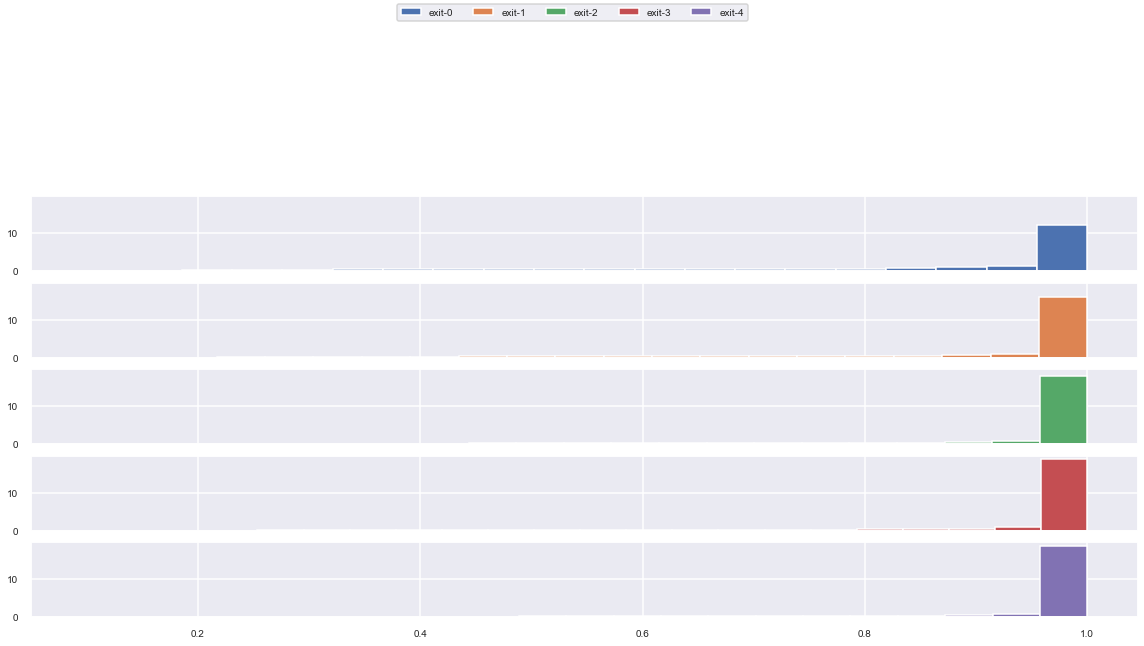

In [8]:
for i, net in enumerate(nets):
    if net == 'msdnet':
        n = 5
    else:
        n = 4
    fig, axes = plt.subplots(n,1, figsize=(16,9), sharex=True, sharey=True)

    for _, d in nets[net]['confidence'].groupby('exit'):
        axes.flat[_].hist(d.score, color=current_palette[_], density=True, bins=20)
    
    fig.tight_layout()
fig.subplots_adjust(top=0.70)
legend = fig.legend(['exit-{}'.format(x) for x in range(n)], ncol=n, loc="upper center", fontsize='medium')
export_legend(legend, 'exits_legend.png')

## number of exited by threshold

In [ ]:
for model in nets:
    correct = nets[model]['confidence'].groupby('exit').correct.mean()
    fig, axes = plt.subplots(2, figsize=(16,9))

for d in data[0][0]:
    axes[0].plot(x, d)
    #plt.xticks()

for d in data[0][3]:
    axes[1].plot(x, d)
    #plt.xticks()
plt.legend(['exit-0', 'exit-1', 'exit-2', 'end'])
plt.show()

## falsely exited

In [ ]:

fig, axes = plt.subplots(2, sharey=True)

for data in th_false_if_exited:
    axes[0].plot(x, data)

for data in sm_false_if_exited:
    axes[1].plot(x, data)
    #plt.xticks()
fig.legend(['exit-0', 'exit-1', 'exit-2', 'end'])
plt.show()

## accuracy only if exited

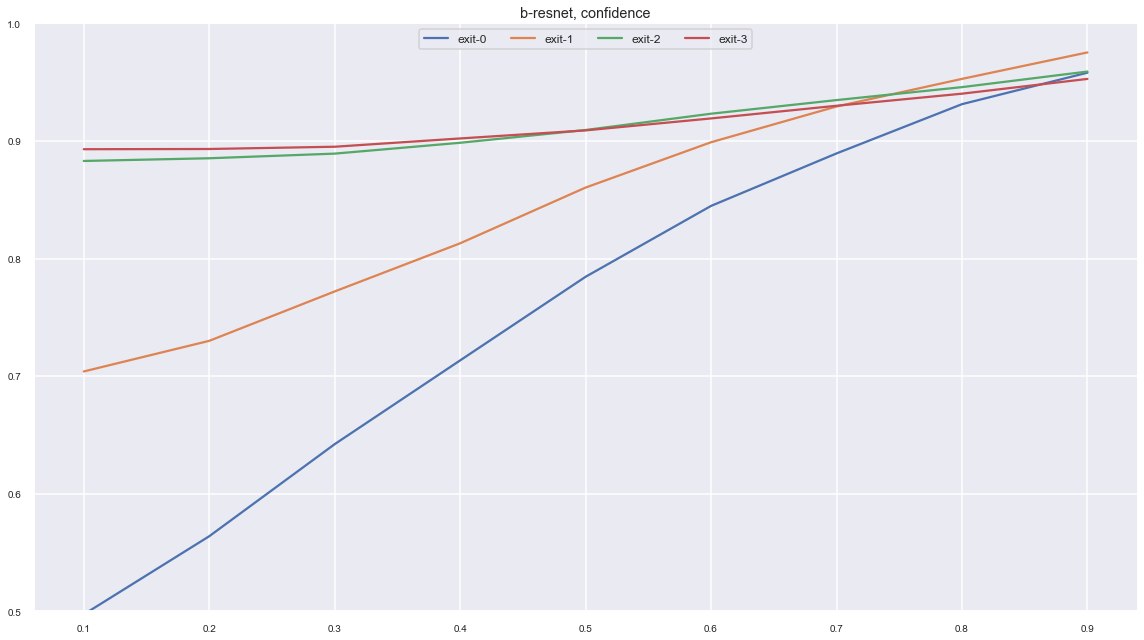

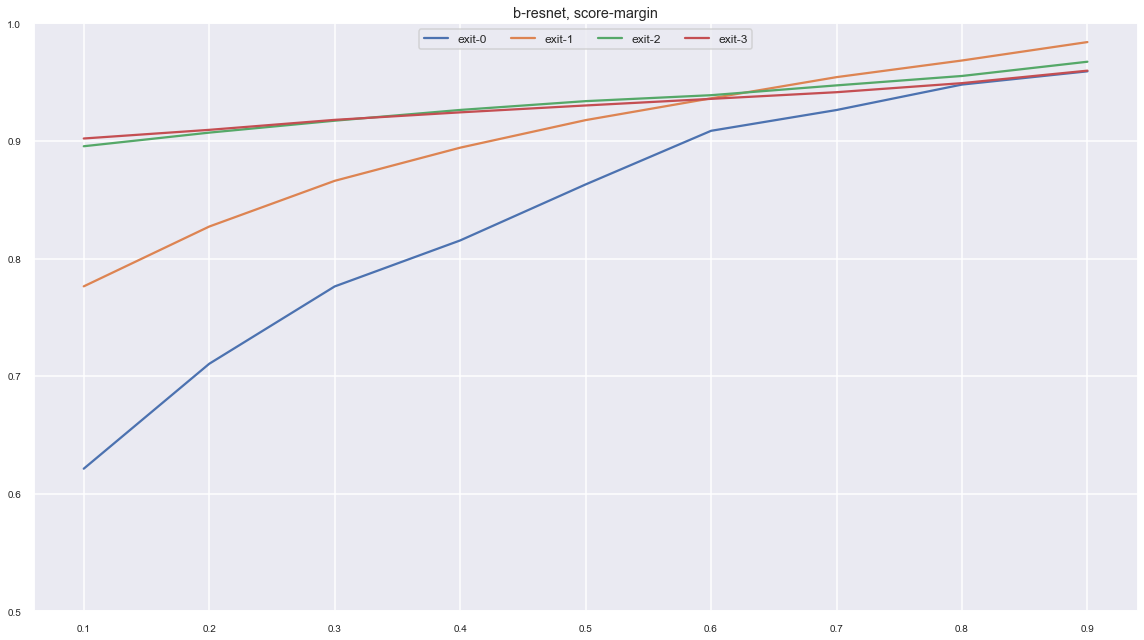

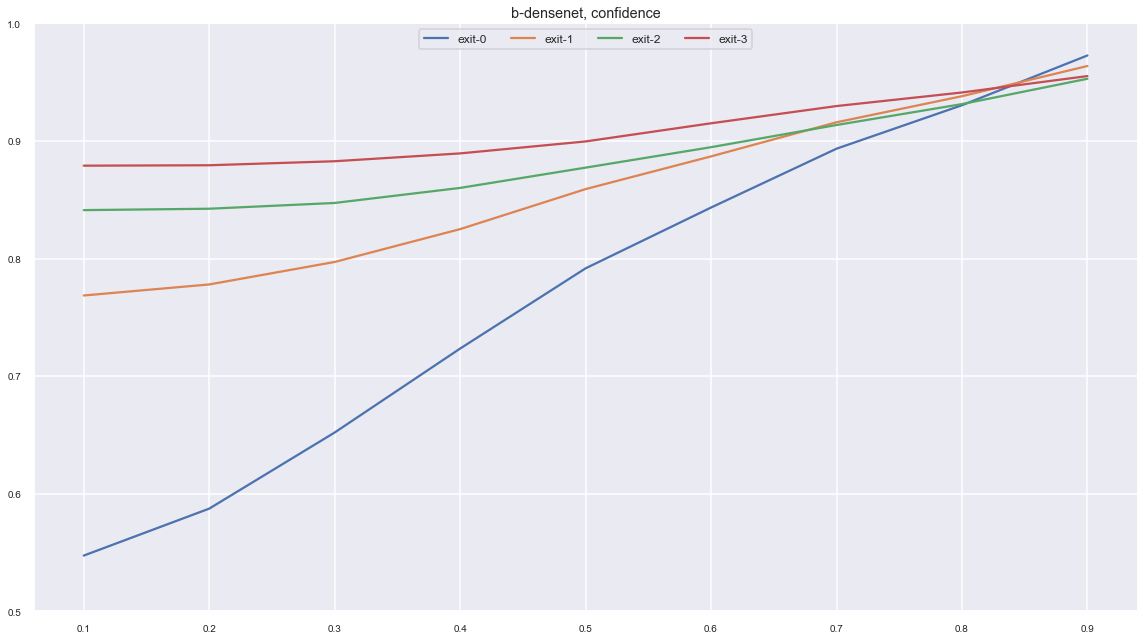

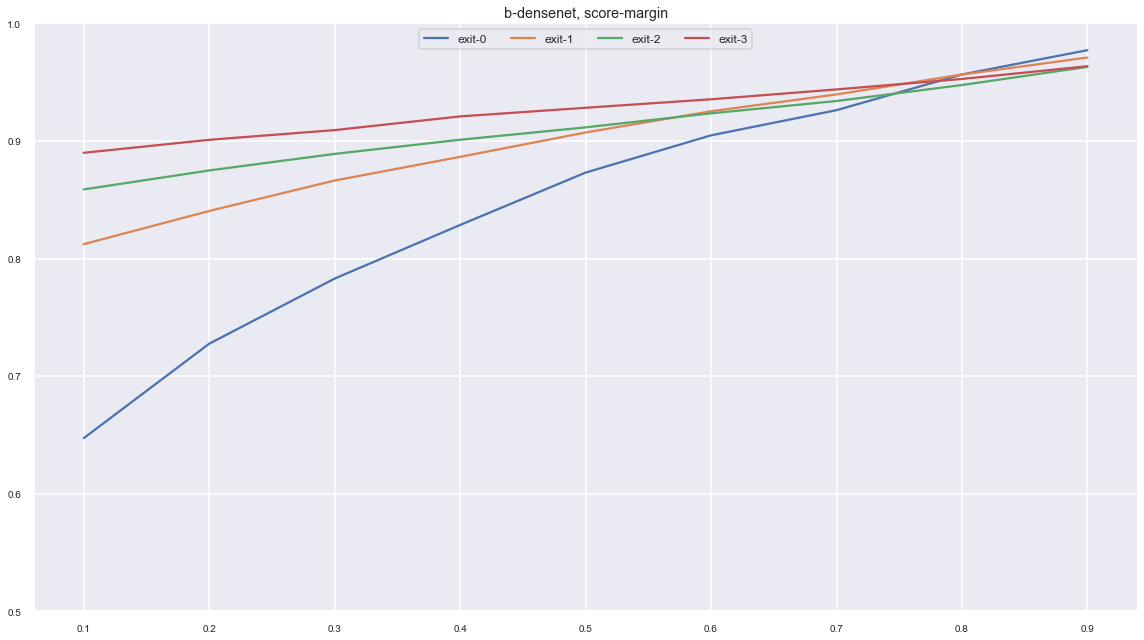

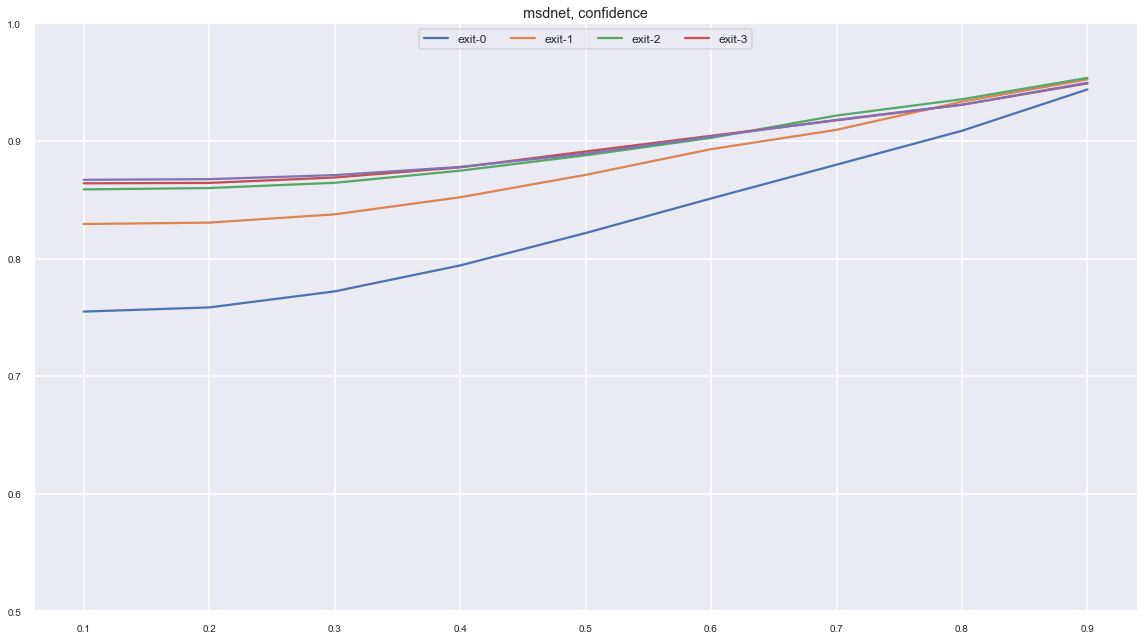

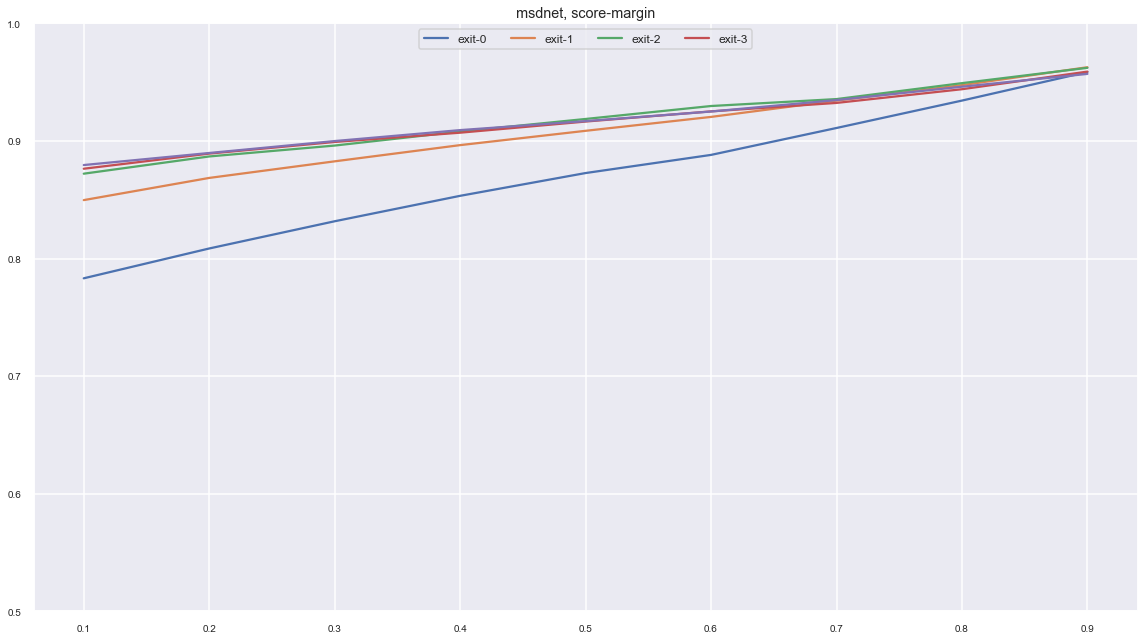

In [9]:
N = np.arange(9)
for model in output:
    for test in output[model]:
        fig, ax = plt.subplots(1,1, figsize=(16,9), sharex=True, sharey=True)
        plt.setp(ax, xticks=N, xticklabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        for exit in range(len(output[model][test]['correct'])):
            accuracy = np.array(output[model][test]['accuracy']['exit-{}'.format(exit)])
            ax.plot(accuracy)
            ax.set_ylim([0.5, 1])
            ax.set_title('{}, {}'.format(model, test))
            plt.legend(['exit-{}'.format(x) for x in range(4)], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=4, fontsize='large')
            fig.tight_layout()
            #fig.subplots_adjust(left=0.15, top=0.95)
        plt.savefig('confidence_analysis_{}_{}_{}.png'.format(model, test, exit))

In [10]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox.expanded(1.05,1.4))

C:\Users\ajk\AppData\Local\Continuum\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


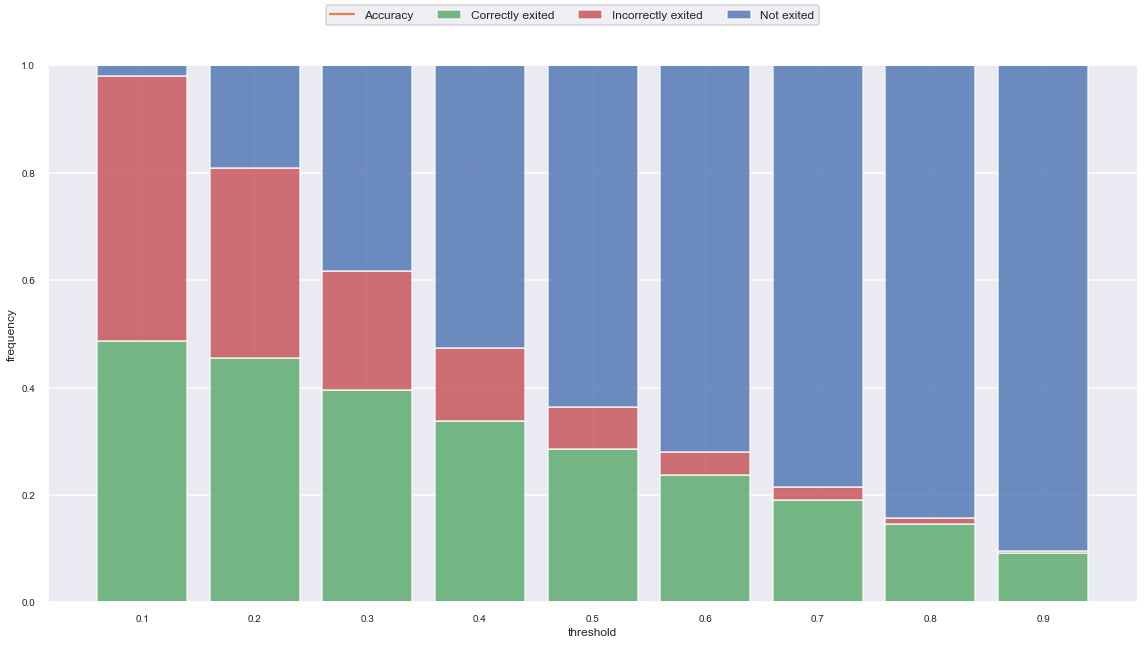

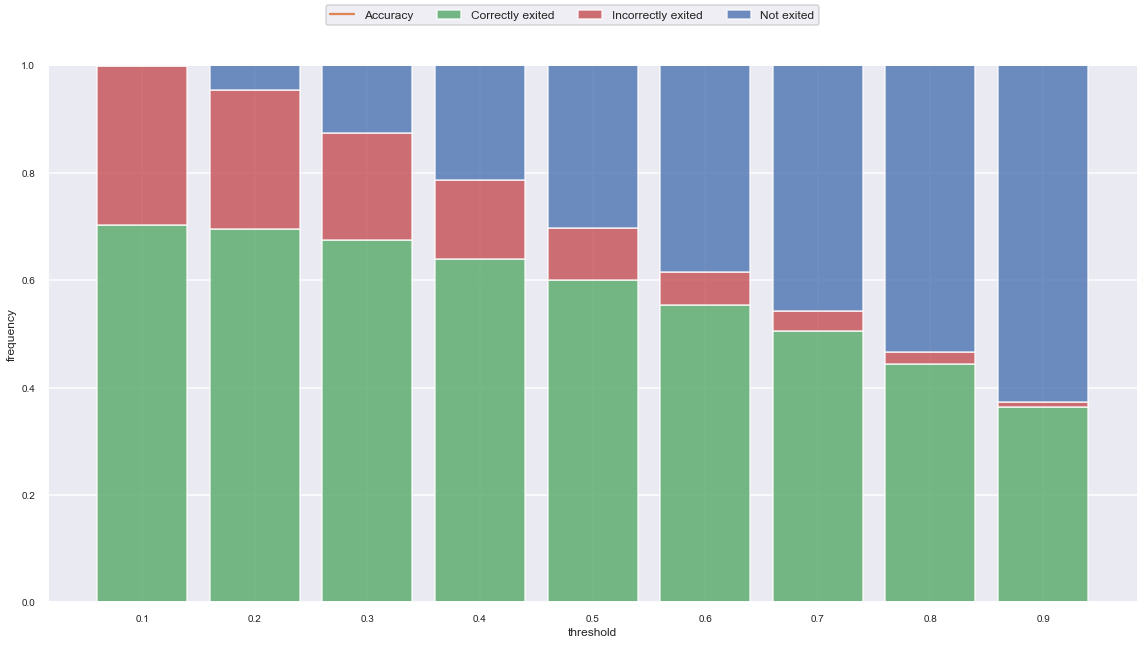

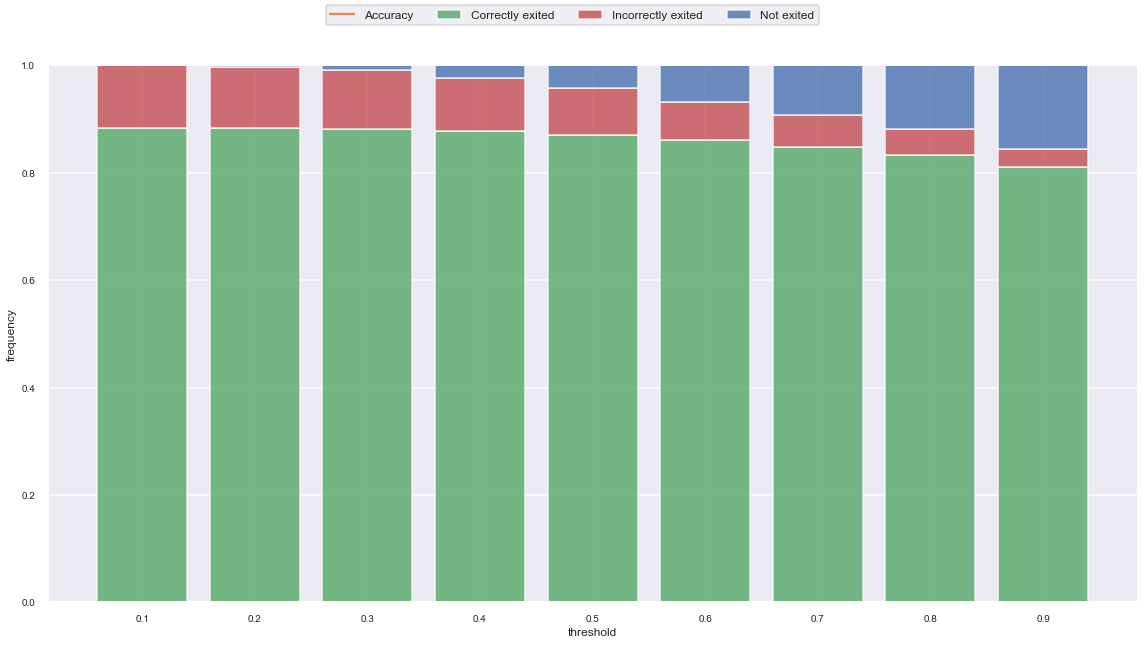

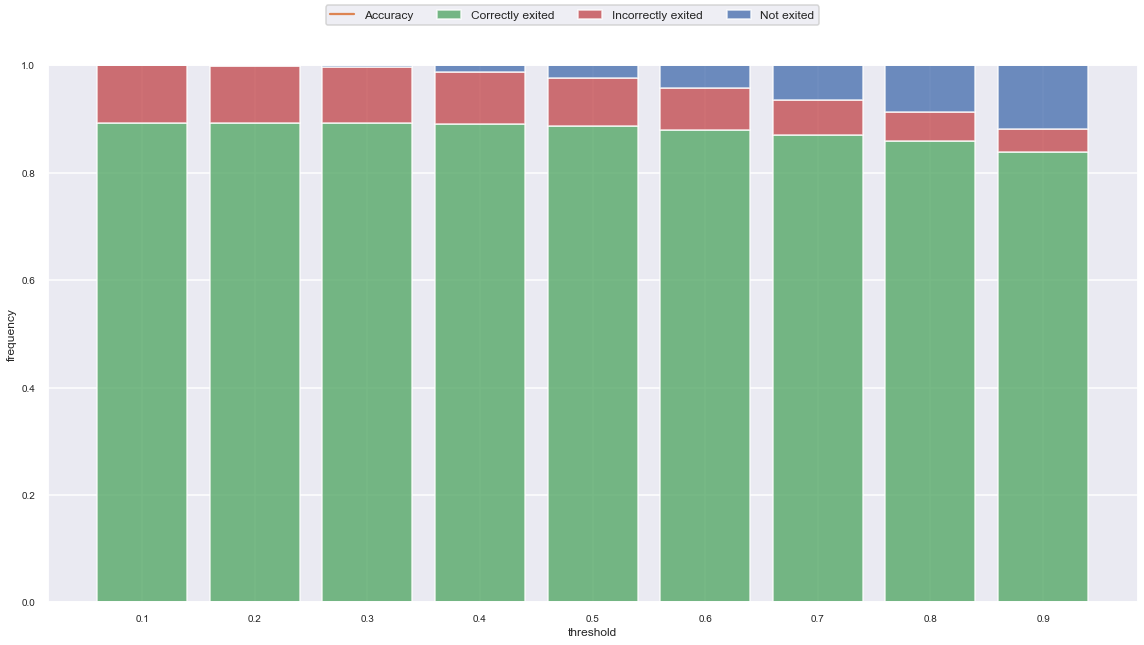

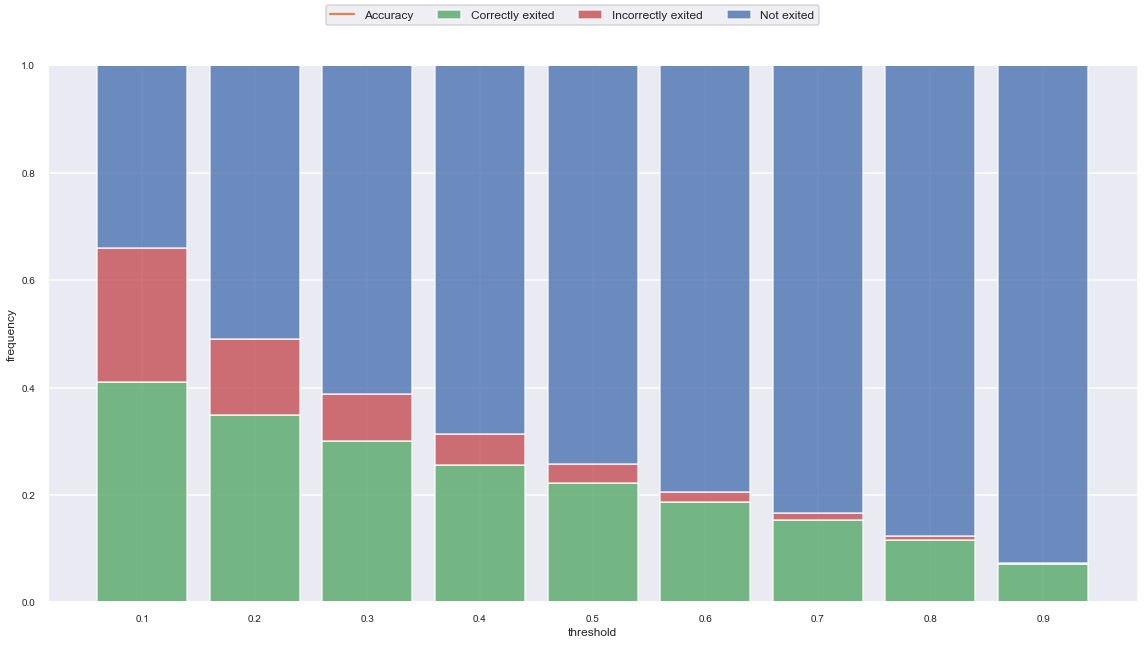

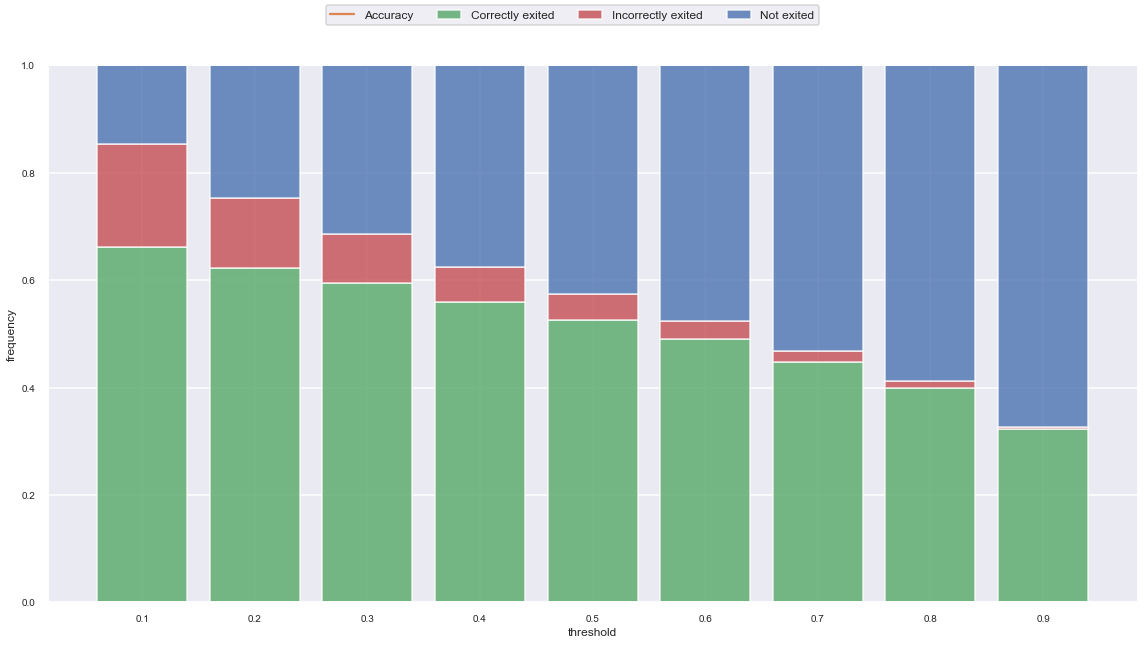

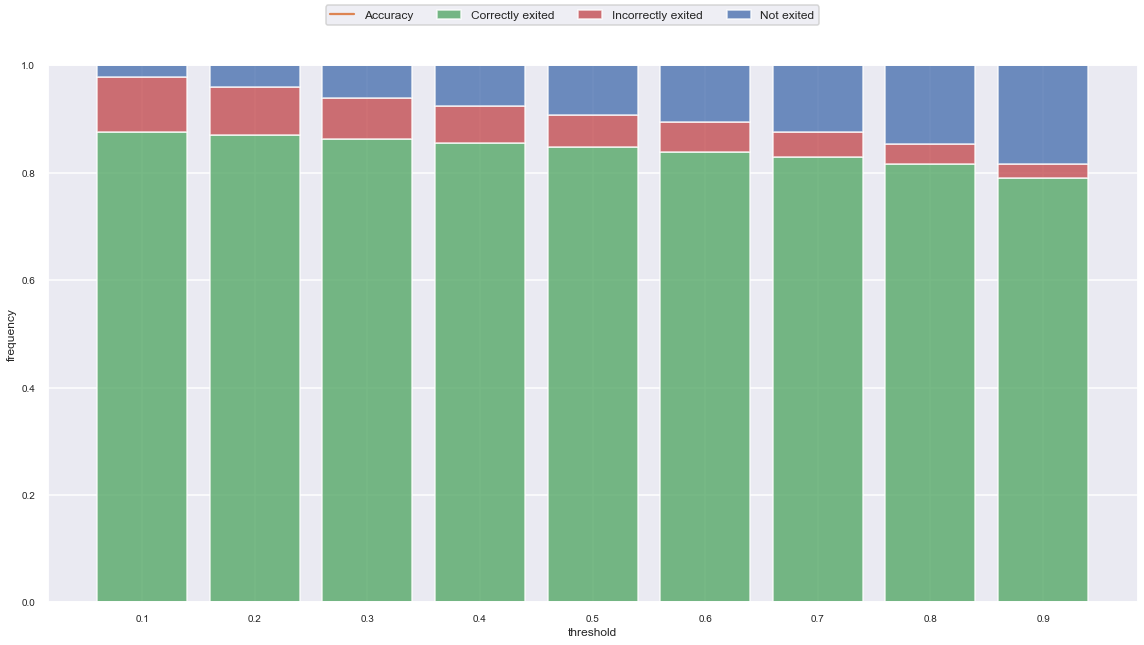

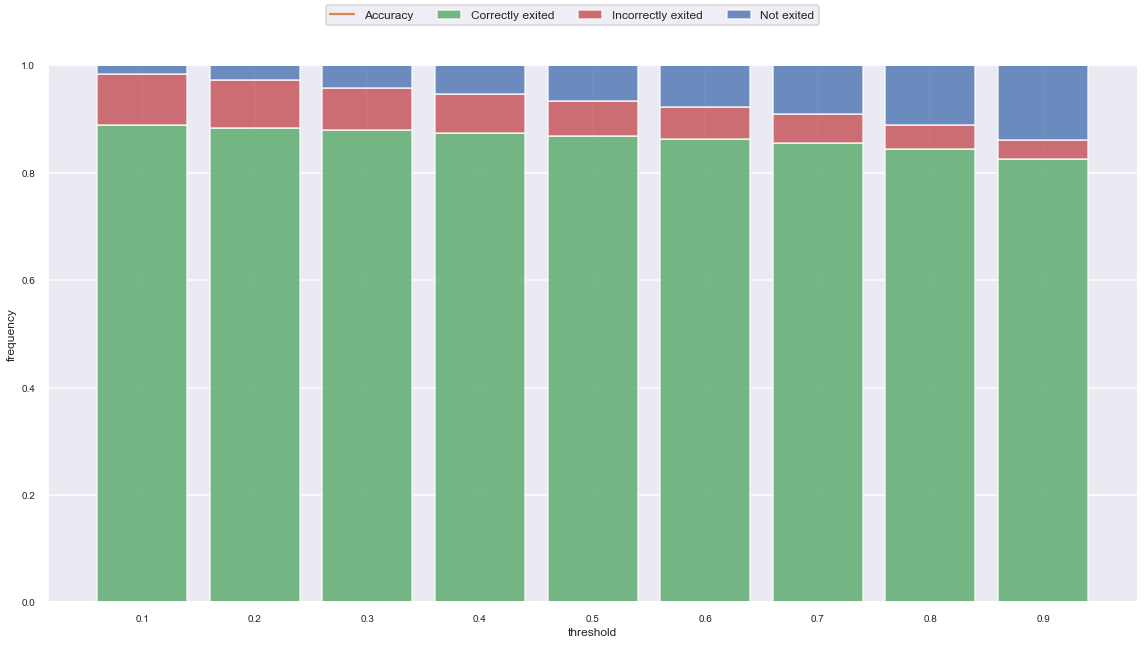

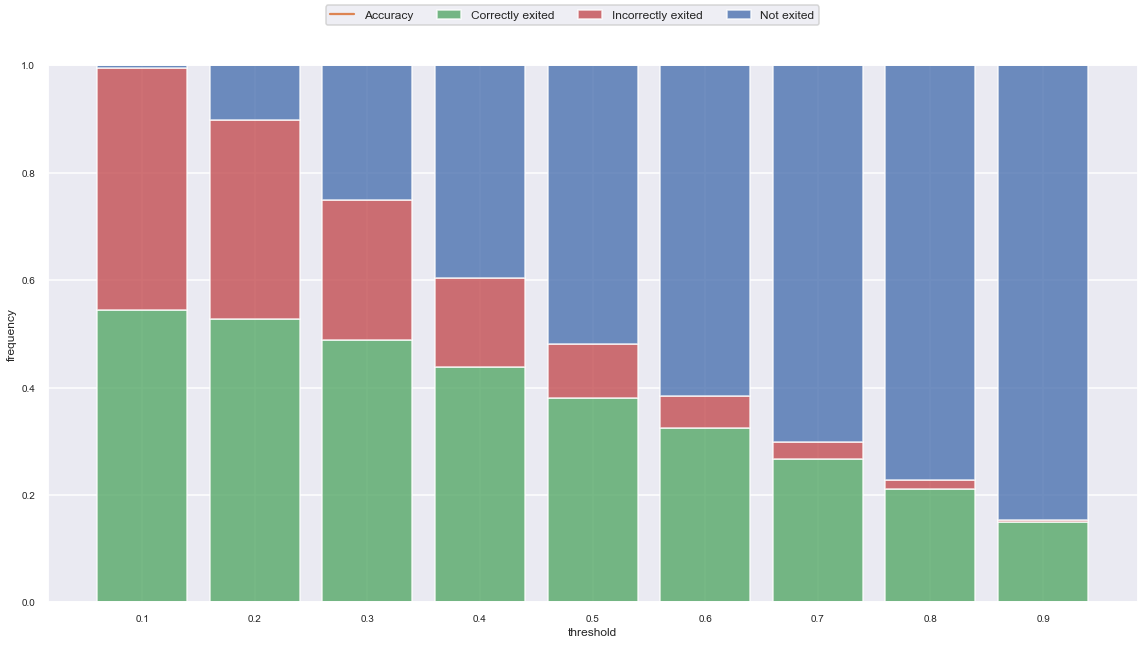

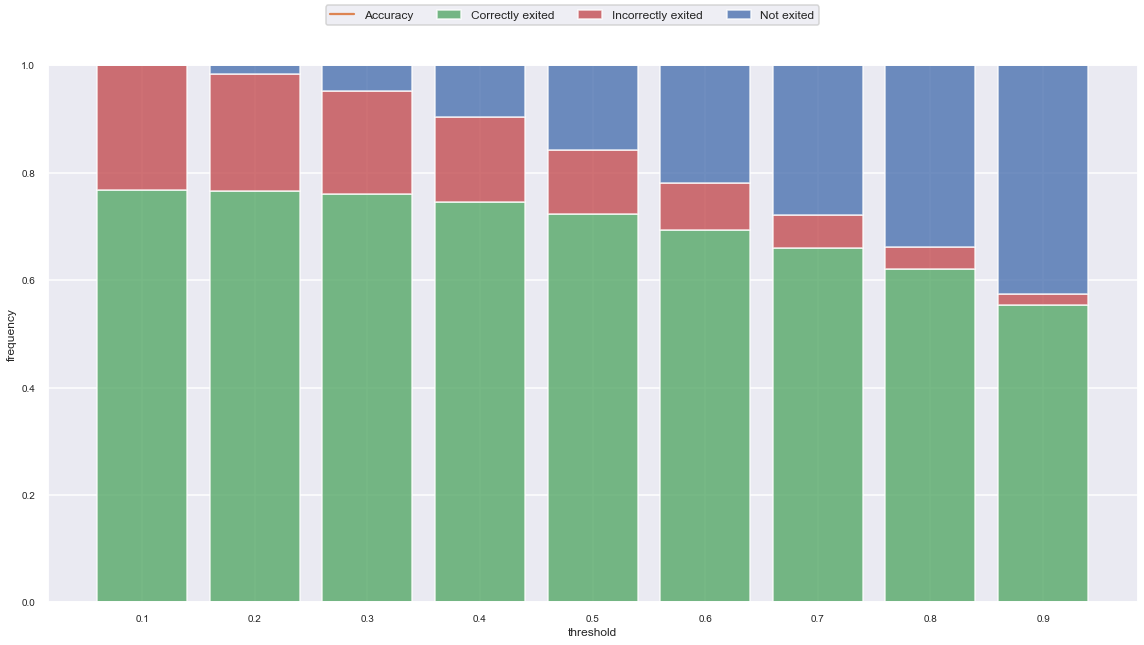

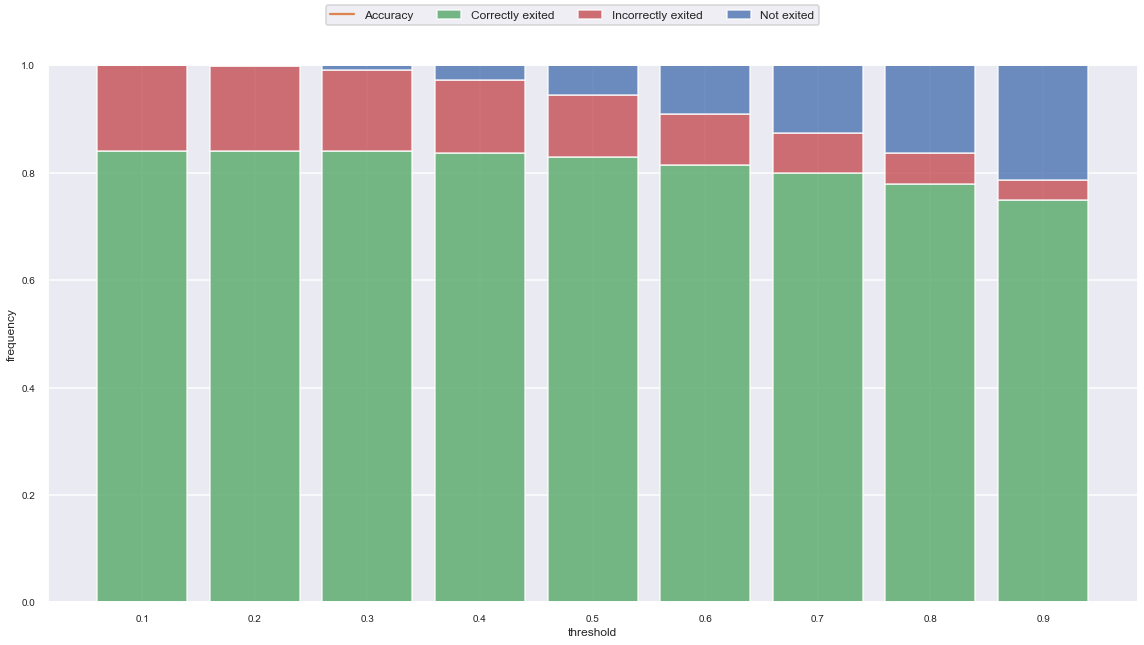

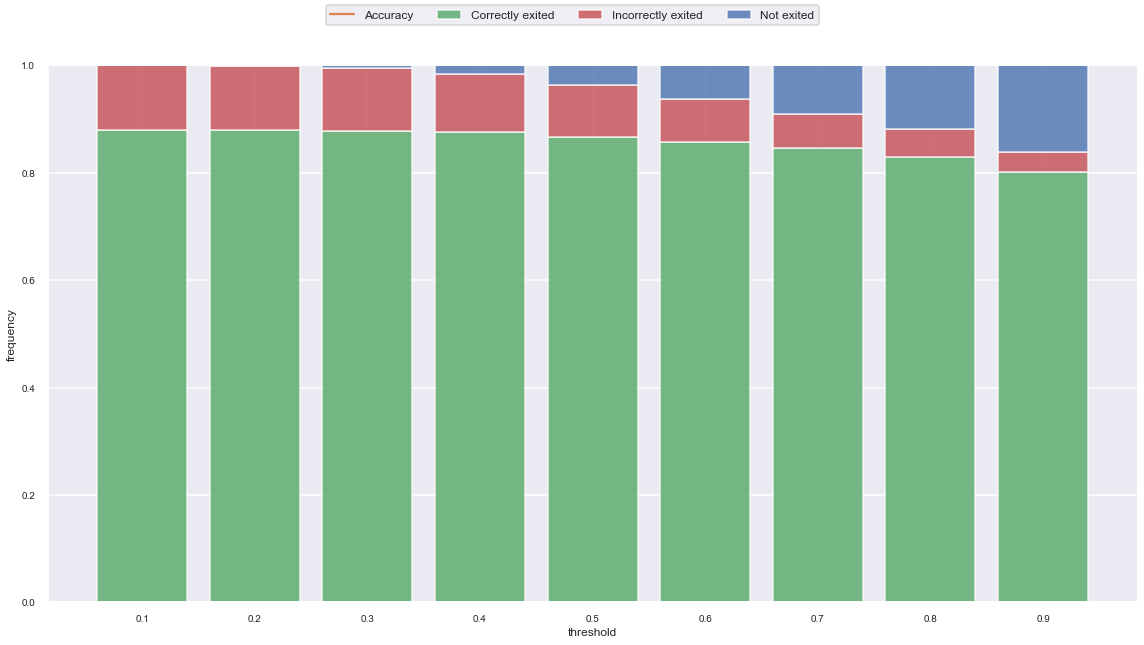

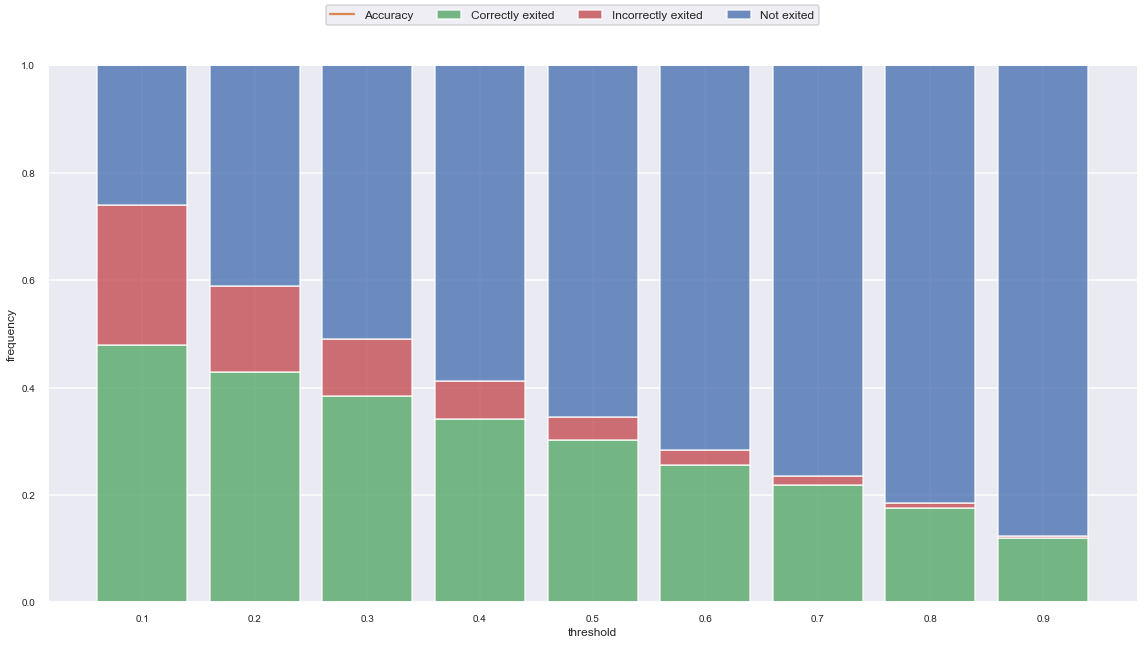

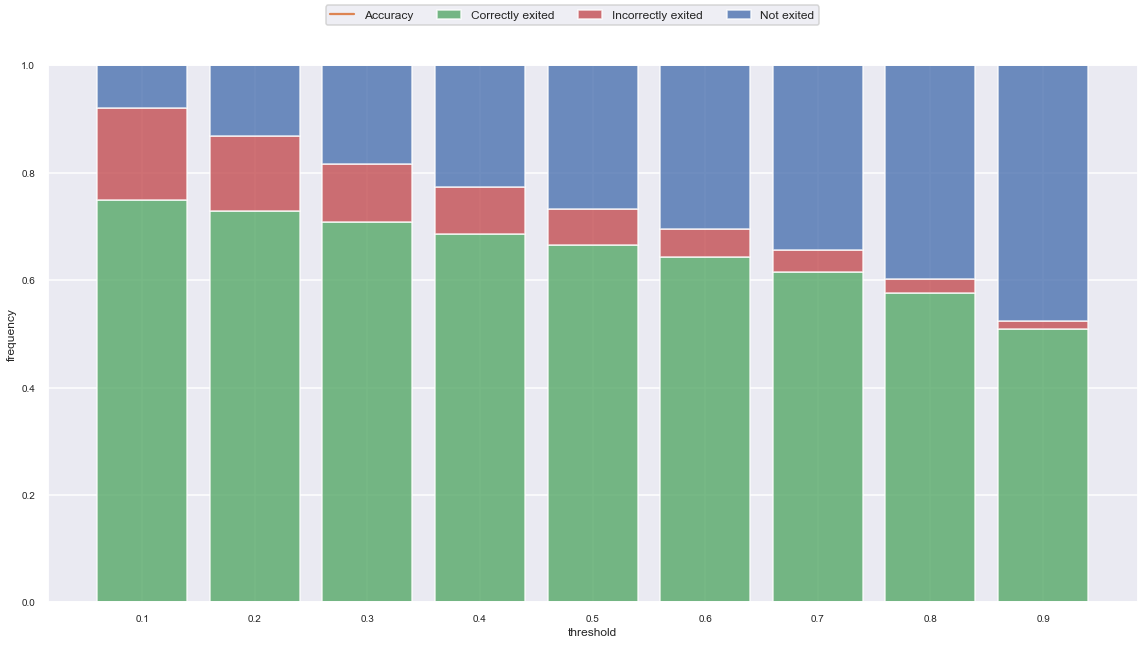

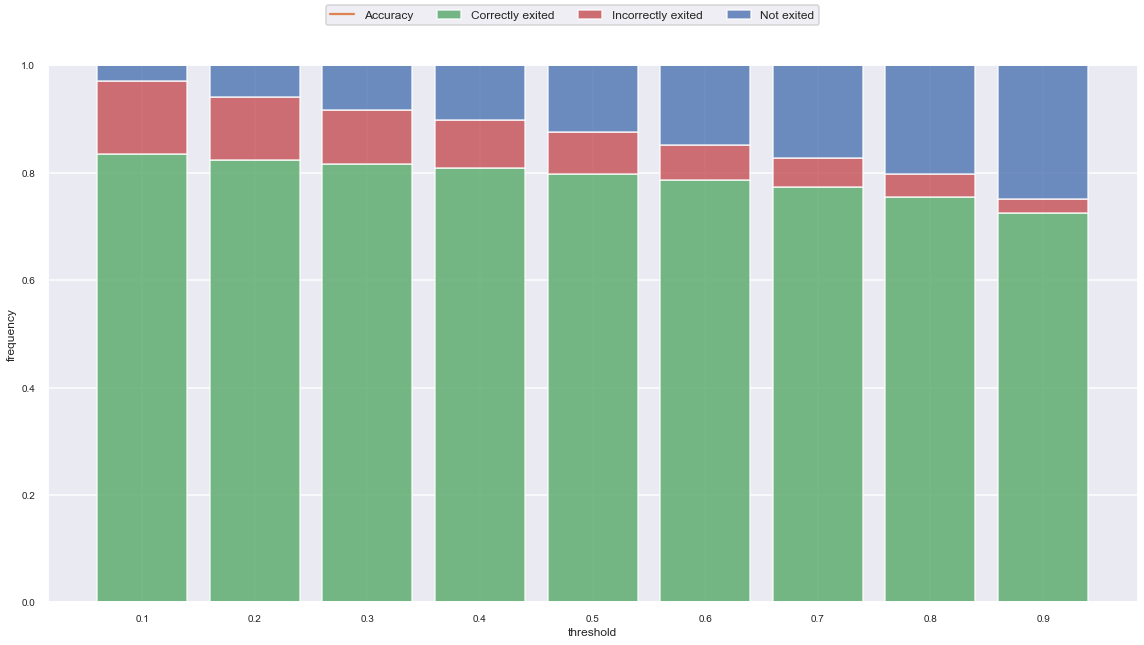

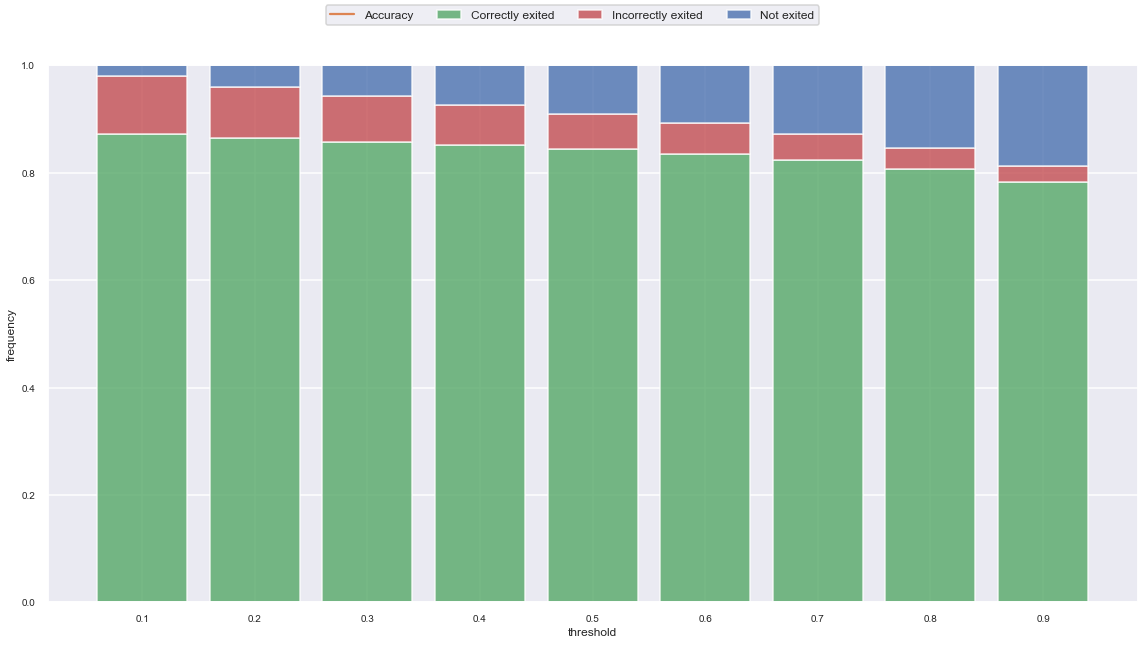

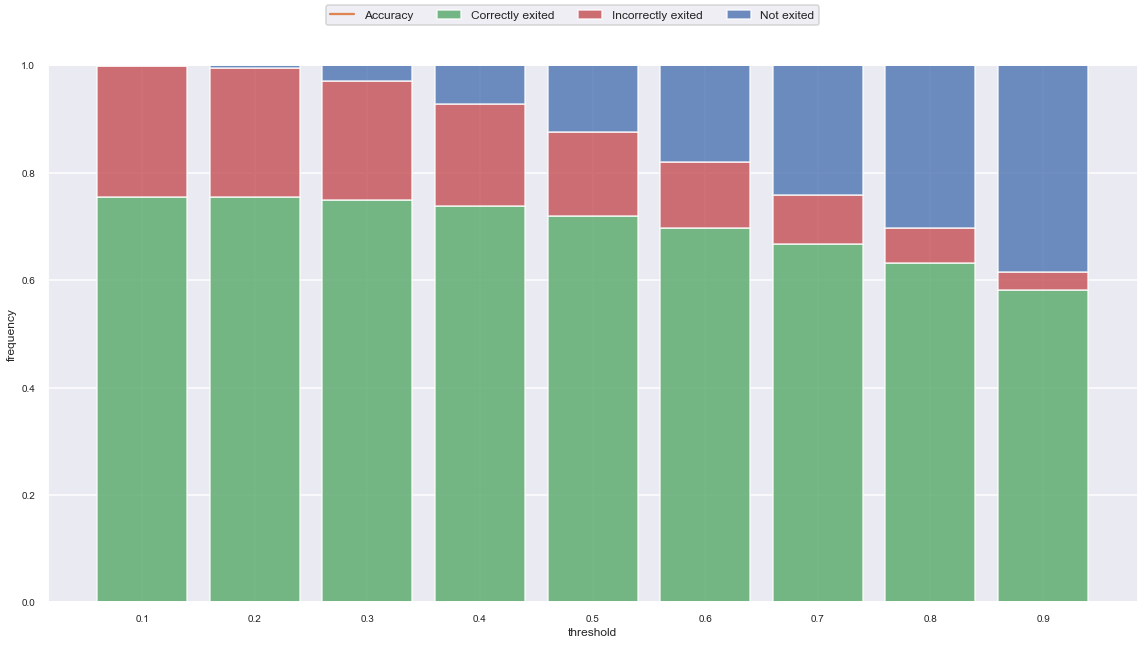

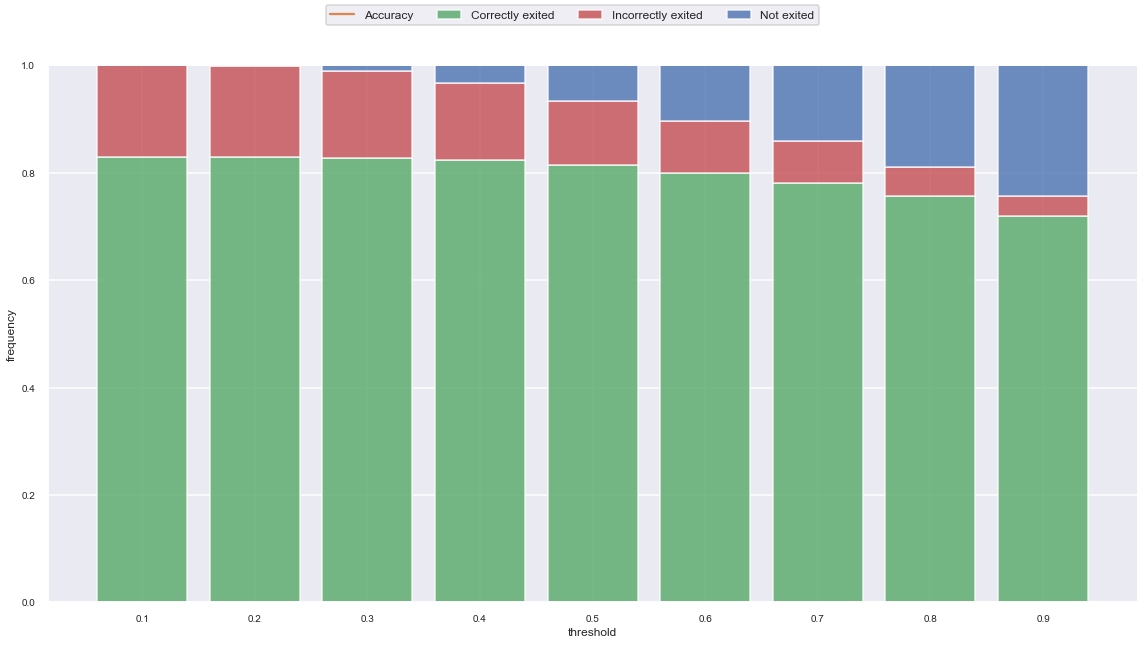

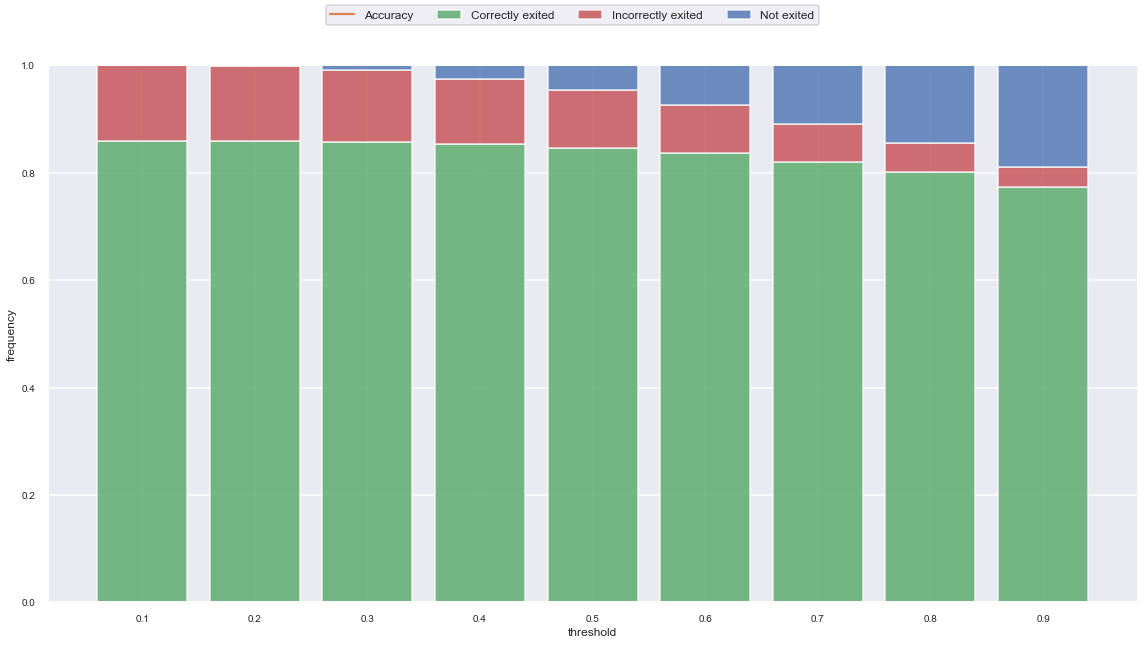

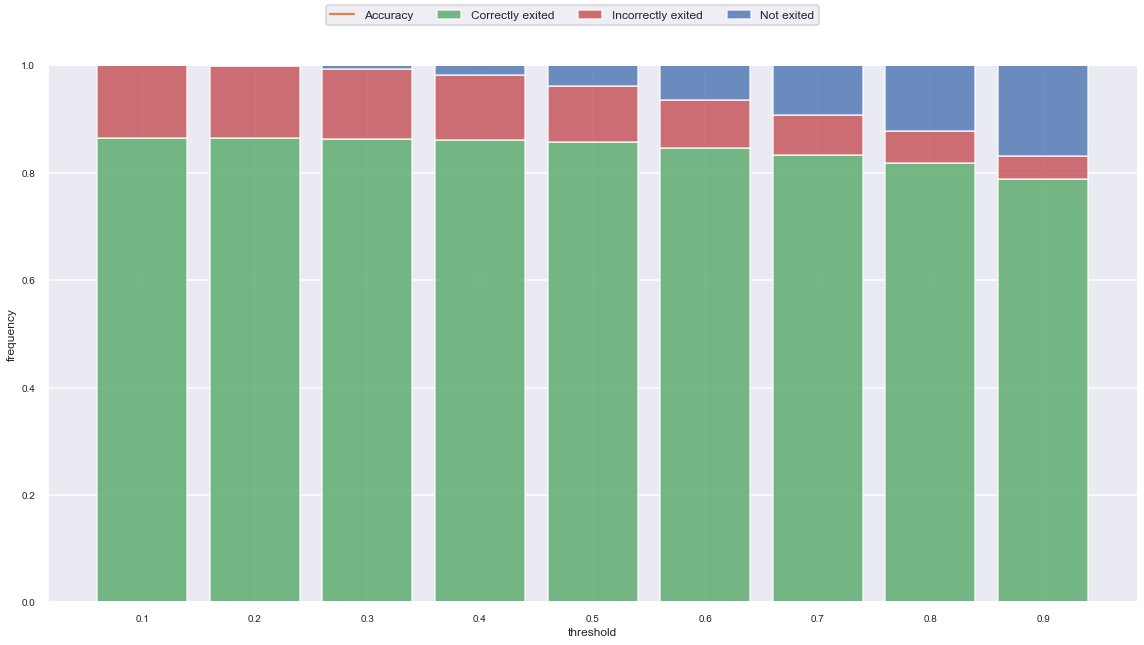

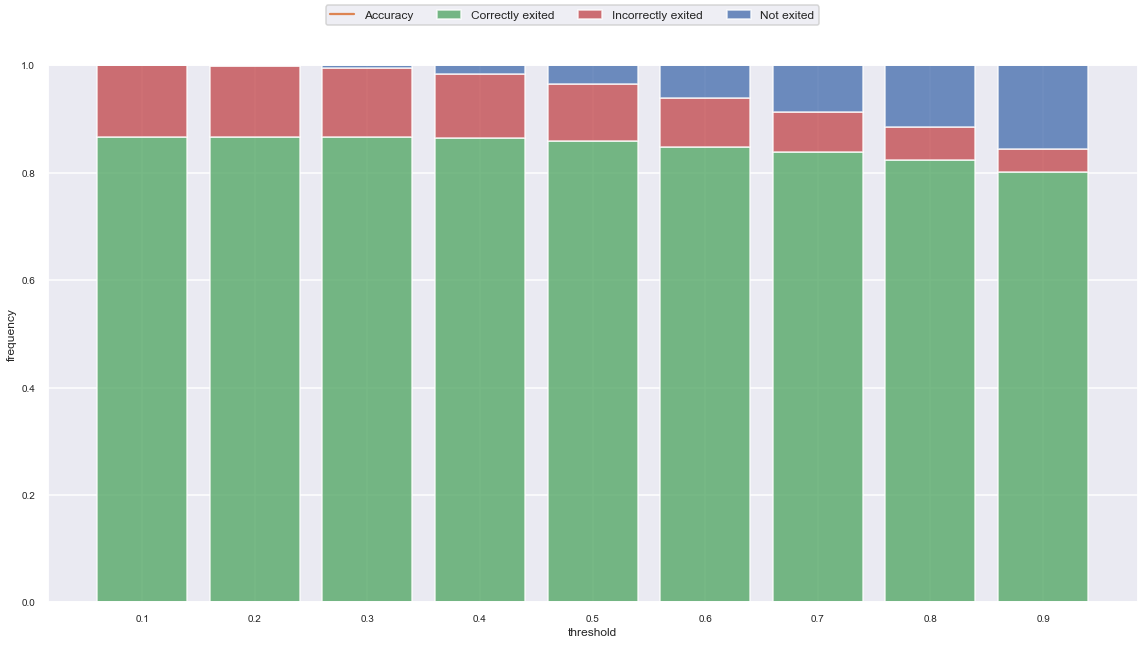

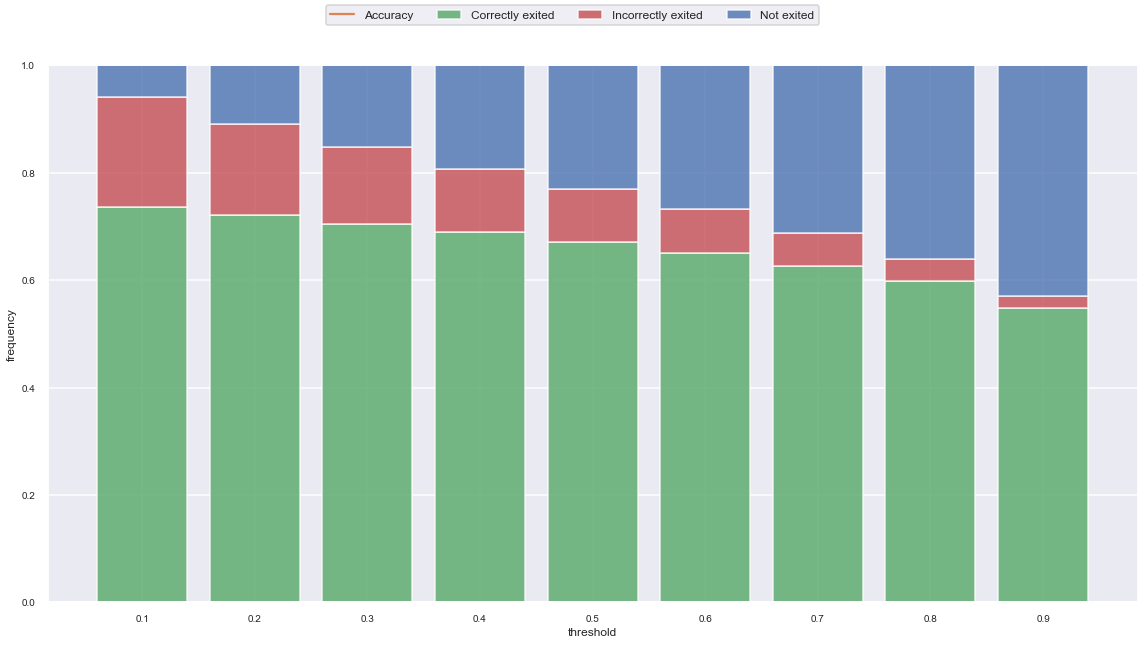

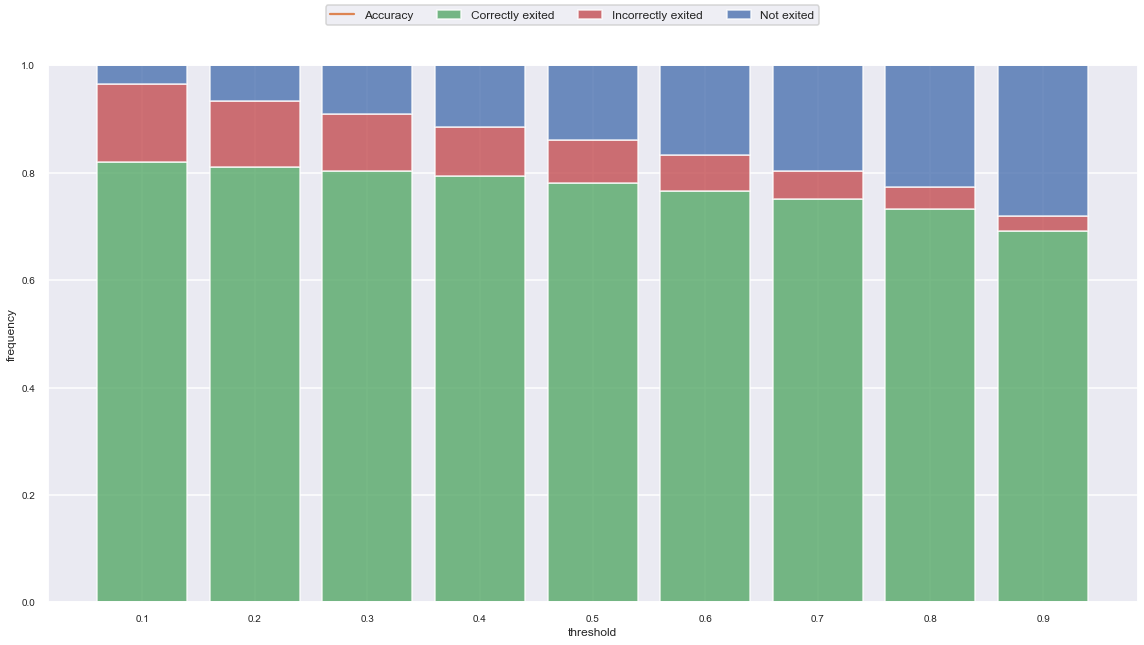

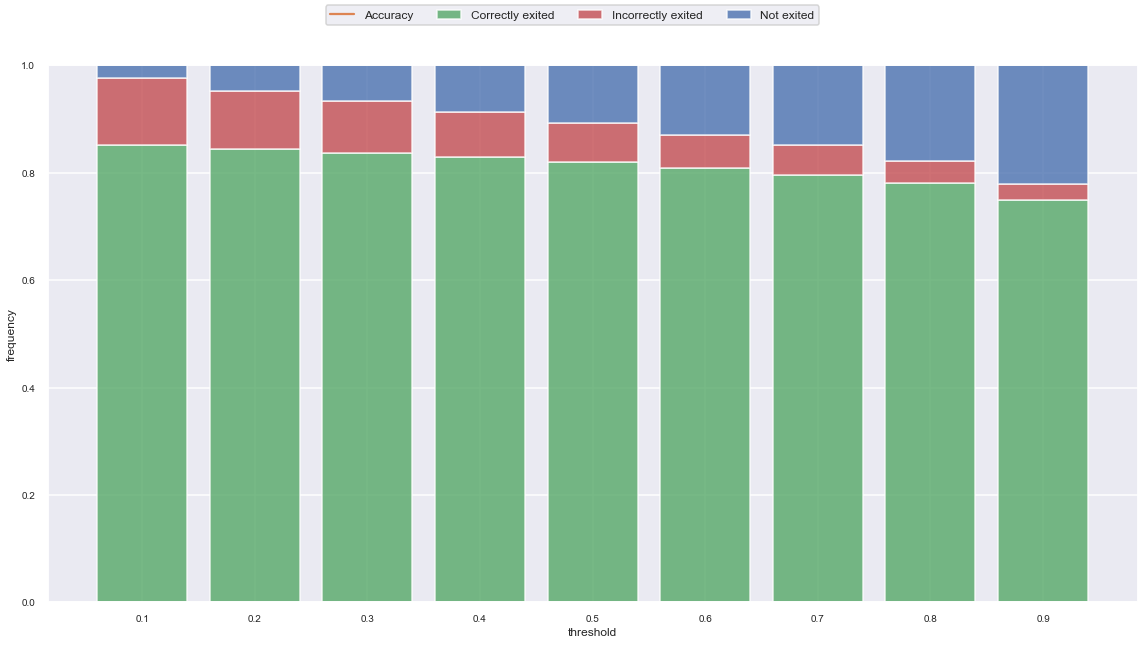

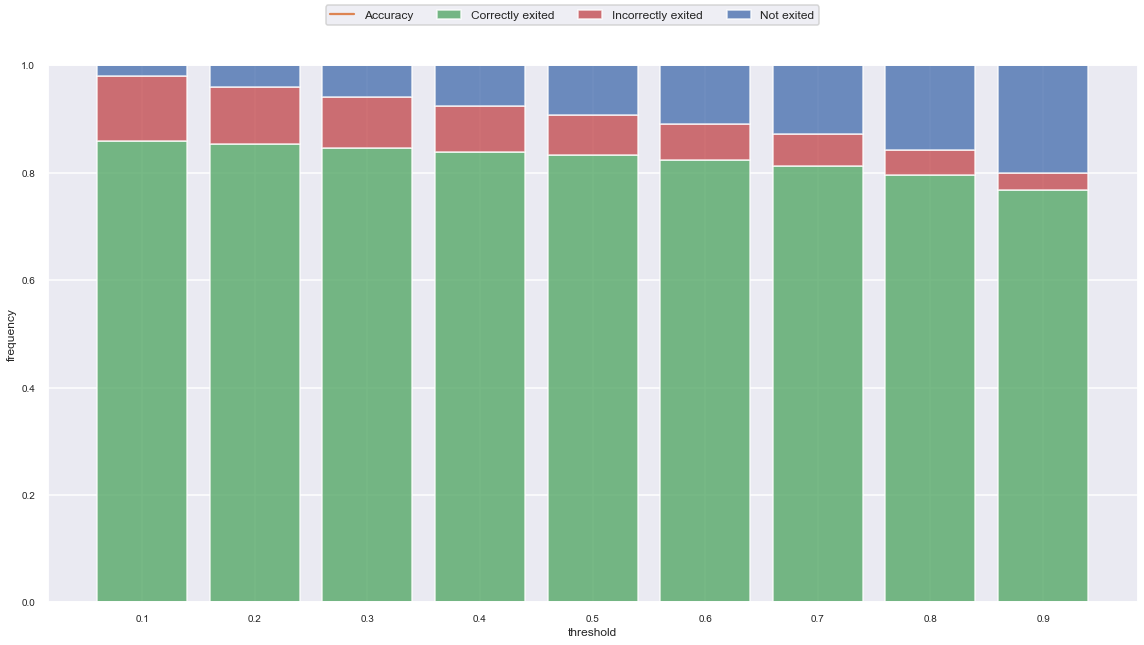

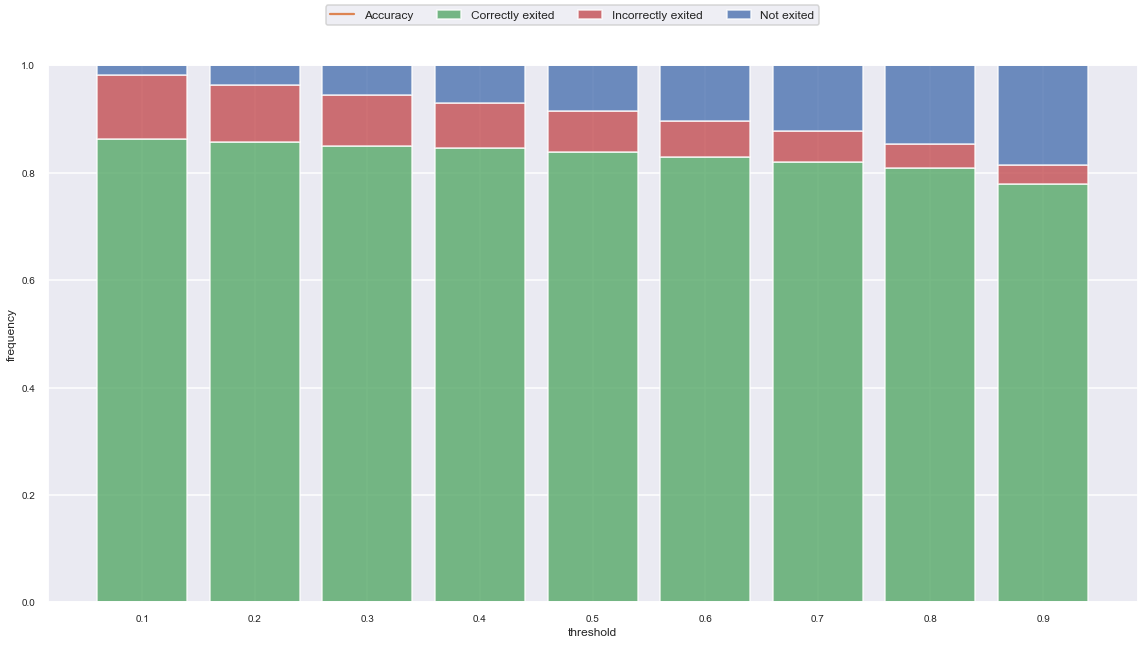

In [11]:
n_samples = 5000
n_thresholds = np.arange(9)



color_palette = sns.color_palette()



for model in output:
    for test in output[model]:
        for exit in range(len(output[model][test]['correct'])):
            fig, ax = plt.subplots(1,1, figsize=(16,9))
            plt.setp(ax, xticks=N, xticklabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
            accuracy = np.array(output[model][test]['accuracy']['exit-{}'.format(exit)])
            correct = np.array(output[model][test]['correct']['exit-{}'.format(exit)])
            incorrect = np.array(output[model][test]['incorrect']['exit-{}'.format(exit)])
            not_exited = n_samples - (correct + incorrect) 

            # normalizing
            correct = correct / n_samples
            incorrect = incorrect / n_samples
            not_exited = not_exited / n_samples

            ax.bar(n_thresholds, correct, color=color_palette[2], alpha=0.8)
            ax.bar(n_thresholds, incorrect, bottom = correct, color=color_palette[3], alpha=0.8)
            ax.bar(n_thresholds, not_exited, bottom = correct + incorrect, color=color_palette[0], alpha=0.8)
            lines = ax.plot(n_thresholds, accuracy, color=color_palette[1])

            #ax.set_title('Exit-{}: {}'.format(exit, test))
            ax.set_ylim([0,1])
            ax.set(xlabel='threshold', ylabel='frequency')
            fig.tight_layout()
            # Put a legend below current axis
            
            
            
            plt.savefig('threshold_analysis_{}_{}_{}.png'.format(model, test, exit))
            
            legend = fig.legend(['Accuracy', 'Correctly exited', 'Incorrectly exited', 'Not exited'], loc='upper center', 
                       #bbox_to_anchor=(0.55, 1),
                  fancybox=True, shadow=False, ncol=4)
            fig.subplots_adjust(top=0.9)
            export_legend(legend, filename='threshold_analysis_legend.png')
            
            l = lines.pop(0).remove()

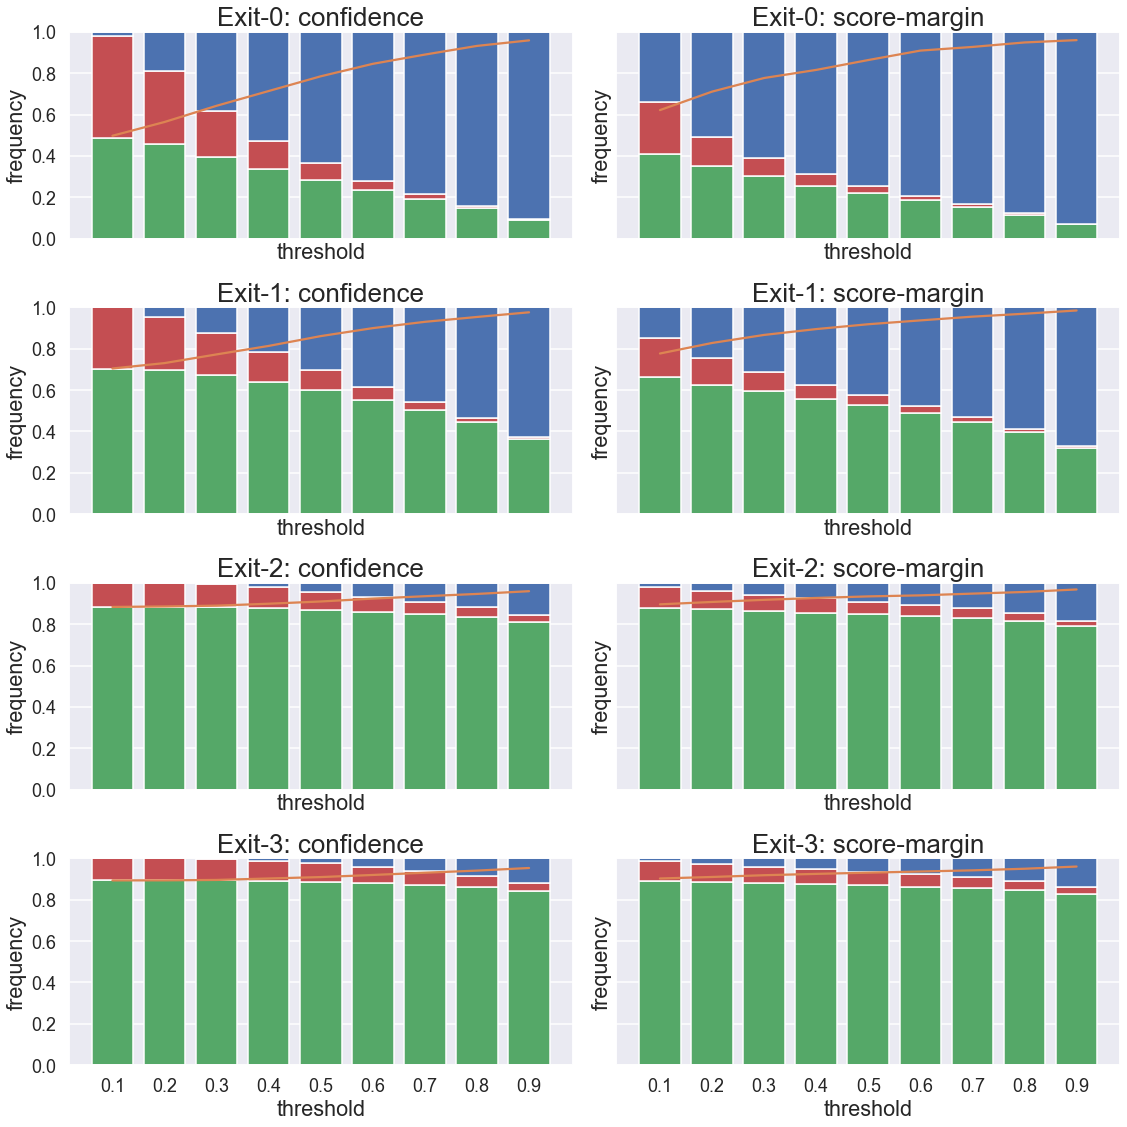

In [13]:
model = 'b-resnet'
fig, axes = plt.subplots(4,2, figsize=(16,16), sharex=True, sharey=True)
for i, test in enumerate(output[model]):
    for exit, ax in zip(range(len(output[model][test]['correct'])),axes[:,i].flat):

        plt.setp(ax, xticks=N, xticklabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        accuracy = np.array(output[model][test]['accuracy']['exit-{}'.format(exit)])
        correct = np.array(output[model][test]['correct']['exit-{}'.format(exit)])
        incorrect = np.array(output[model][test]['incorrect']['exit-{}'.format(exit)])
        not_exited = n_samples - (correct + incorrect) 

        # normalizing
        correct = correct / n_samples
        incorrect = incorrect / n_samples
        not_exited = not_exited / n_samples

        ax.bar(n_thresholds, correct, color=color_palette[2])
        ax.bar(n_thresholds, incorrect, bottom = correct, color=color_palette[3])
        ax.bar(n_thresholds, not_exited, bottom = correct + incorrect, color=color_palette[0])
        ax.plot(n_thresholds, accuracy, color=color_palette[1])
        
        ax.set_title('Exit-{}: {}'.format(exit, test))
        ax.set_ylim([0,1])
        ax.set(xlabel='threshold', ylabel='frequency')
        #ax.label_outer()
        fig.tight_layout()
        
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('ax2_figure.png', bbox_inches=extent.expanded(1, 1.4))
